## Imports

In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# ## importing stuff
# import os
# import pickle
# from sys import path as syspath
# syspath.append(os.path.expanduser("~/srdjan_functs/"))
# import numpy as np
# np.corrcoef(*np.random.randn(2,3))
# import matplotlib.pyplot as plt
# import warnings
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     from caiman import movie as cmovie
#     from caiman import load  as cload

# %config InlineBackend.figure_format = 'retina'
# %load_ext autoreload
# %autoreload 2

# import PicklePicker as pp
# from IPython.display import display
# import pandas as pd
# from islets.Recording import Recording, saveMovie
# from islets.Regions1 import Regions
# from islets.numeric import power_spectrum, rebin
# from islets.utils import show_movie, saveRois
# from matplotlib.colors import LogNorm
# from islets.Recording import import_data
# from islets.Regions1 import load_regions
# from islets.utils import rgb_to_hex

# import bioformats as bf


In [ ]:
%run process_single_4.py -rec="/data/Sandra/2019/2019_07_01/Experiment22.lif" -ser="Series025" --verbose --debug --restrict="10_500"

importing modules...
importing series...
/data/Sandra/2019/2019_07_01/Experiment22.lif_analysis/Series025_10-500s exists already.
Resizing the movie resolution by 2...
Writing the movie...
placed dummy protocol file at /data/Sandra/2019/2019_07_01/Experiment22.lif_analysis/Series025_10-500s/Experiment22.lif_Series025_protocol.txt
		 ##### (5,)
processing with filter size of  (5,)
initiallized with 1226 rois.
		 ##### (6,)
processing with filter size of  (6,)


In [ ]:
# regions.plotTraces(regions.df.index, col="trace")

In [ ]:
# del regions.metadata

In [ ]:
regions.merge_closest(plot=True, Niter=2)

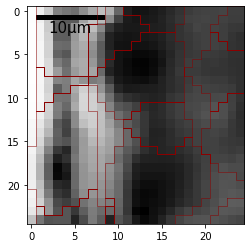

In [3]:
regions.plotEdges()

In [2]:
# saveMovie(movie,"embed")

In [4]:
from IPython.display import Video
Video(movieFilename, embed=True)

In [9]:
HTML(f"""
    <video alt="test" width="320" height="240" controls>
        <source src="{movieFilename}" type="video/mp4">
    </video>
""")


In [2]:
rec = Recording()

In [3]:
serToImport = "Series025"

In [4]:
restrict = (10,-3000)

In [5]:
bf.javabridge.start_vm(class_path=bf.JARS)
rec.import_series(serToImport, restrict=restrict)
bf.javabridge.kill_vm()

In [13]:
movie = cmovie(
    rec.Series[serToImport]["data"],
    fr = rec.Series[serToImport]["metadata"]["Frequency"],
              )

In [14]:
metadata = rec.Series[serToImport]["metadata"]

In [15]:
# show_movie(movie[:,::2,::2].astype("float32")+1, autoadjust=False, log=True)

In [16]:
movie = movie.resize(.5,.5,1)

In [17]:
show_movie(movie[:3])

In [12]:
metadata.pxSizeze

AttributeError: 'Series' object has no attribute 'pxSizeze'

In [18]:
#     if len(pathToCorrected):
#         movie = cload(
#             pathToCorrected,
#             fr=metadata.Frequency,
#             outtype=metadata['bit depth']
#         )
#         FrameRange = metadata.frame_range
#         movie = movie[FrameRange[0]:FrameRange[1]]
#     else:
#         movie = cmovie(
#             rec.Series[serToImport]['data'],
#             fr=metadata.Frequency
#         )

In [27]:
# ser = serToImport

In [28]:
saveDir = os.path.join(rec.folder, rec.Experiment+"_analysis", ser)

In [29]:
if len(rec.metadata)==1:
    movieFilename = os.path.join(saveDir, os.path.splitext(rec.Experiment)[0]+".mp4")
else:
    movieFilename = os.path.join(saveDir, rec.Experiment+"_"+ser+".mp4")

In [42]:
movie.fr = None

In [31]:
# metadata.pxSize

In [ ]:
def process_movie(movie, metadata, test=False, debug=False, verbose=0):
    


    if metadata.pxSize<.8:
        if args.verbose: print ("Resizing the movie resolution by 2...")
        movie = movie.resize(1/2,1/2,1)
        metadata.pxSize *= 2
        metadata.SizeX /= 2
        metadata.SizeY /= 2

    writeMovie = True
    if os.path.isfile(movieFilename):
        if args.verbose: print("Movie already exists, ", end="")
        if args.leave_movie:
            writeMovie = False
            if args.verbose: print("and I leave it be.")
        else:
            if args.verbose: print("and I'll rewrite it.")
    if writeMovie:
        if args.verbose: print("Writing the movie...")
        if not args.test: saveMovie(movie,movieFilename)

    if not args.only_movie: 


        #### protocol filename
        protocolFilename = movieFilename.replace(".mp4", "_protocol.txt")
        if not os.path.isfile(protocolFilename):
            if args.verbose: print("placed dummy protocol file at", protocolFilename)
            if not args.test:
                DataFrame([[None]*4],columns=["compound","concentration","begin","end"]).to_csv(protocolFilename,index=False)

        filtSizes = get_filterSizes(metadata.pxSize)

        # anull saturated above threshold
#         Nsatur = (movie==movie.max()).sum(0)
#         toAnull = np.where(Nsatur>len(movie)*fracSaturTh)
#         movie[(slice(None), )+toAnull] = 0


        for spFilt in filtSizes:
            if args.verbose: print ("\t"*2,"#"*5,spFilt)

            pickleFile = os.path.join(saveDir, ".".join(map(str,spFilt))+"_rois.pkl")
            if os.path.isfile(pickleFile) and args.leave_pickles:
                if args.verbose: print ("already exists, skipping.")
                continue
            else:
                if args.verbose: print ("processing with filter size of ", spFilt)

            regions = Regions(movie,gSig_filt=spFilt,diag=True)
            regions.time += t0
            if args.verbose:
                print (f"initiallized with {len(regions.df)} rois.")

            regions.purge_lones((min(spFilt)*.4)**2, verbose=args.verbose)
            regions.sortFromCenter()
            regions.calcTraces()
            regions.metadata = metadata
            if not args.test: 
                saveRois(regions, saveDir, filename= ".".join(map(str,spFilt)), add_date=False, formats=["vienna"])

            # preview image
            del regions